In [ ]:
import warnings

import wqet_grader

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 3 Assessment")

In [ ]:
# Import libraries here
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.filterwarnings("ignore")

# Prepare Data

## Connect

**Task 3.5.1:** Connect to MongoDB server running at host `"localhost"` on port `27017`. Then connect to the `"air-quality"` database and assign the collection for Dar es Salaam to the variable name `dar`.

In [ ]:
client = MongoClient(host='localhost',port= 27017)
db = client['air-quality']
dar = db['dar-es-salaam']
dar

Explore
Task 3.5.2: Determine the numbers assigned to all the sensor sites in the Dar es Salaam collection. Your submission should be a list of integers. 

In [ ]:
sites = dar.distinct('metadata.site')
sites

In [ ]:
Task 3.5.3: Determine which site in the Dar es Salaam collection has the most sensor readings (of any type, not just PM2.5 readings). You submission readings_per_site should be a list of dictionaries that follows this format:

[{'_id': 6, 'count': 70360}, {'_id': 29, 'count': 131852}]

In [ ]:
result = dar.aggregate([{'$group':{'_id':'$metadata.site','count':{'$count':{}}}}])
readings_per_site = list(result)
readings_per_site

## Import

**Task 3.5.4:** Create a `wrangle` function that will extract the PM2.5 readings from the site that has the most total readings in the Dar es Salaam collection. Your function should do the following steps:

1. Localize reading time stamps to the timezone for `"Africa/Dar_es_Salaam"`.
2. Remove all outlier PM2.5 readings that are above 100. 
3. Resample the data to provide the mean PM2.5 reading for each hour.
4. Impute any missing values using the forward-fill method. 
5. Return a Series `y`. 

In [ ]:
def wrangle(collection):

    results = collection.find(
        {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read results into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

    # Remove outliers
    df = df[df["P2"] < 100]

    # Resample and forward-fill
    y = df.resample('1H')['P2'].mean().fillna(method='ffill')

    return y

In [ ]:
y = wrangle(dar)
y

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(title="Dar es Salaam PM2.5 Levels", xlabel="Date", ylabel="PM2.5 Level", ax=ax)

# Don't delete the code below 👇
plt.savefig("images/3-5-5.png", dpi=150)

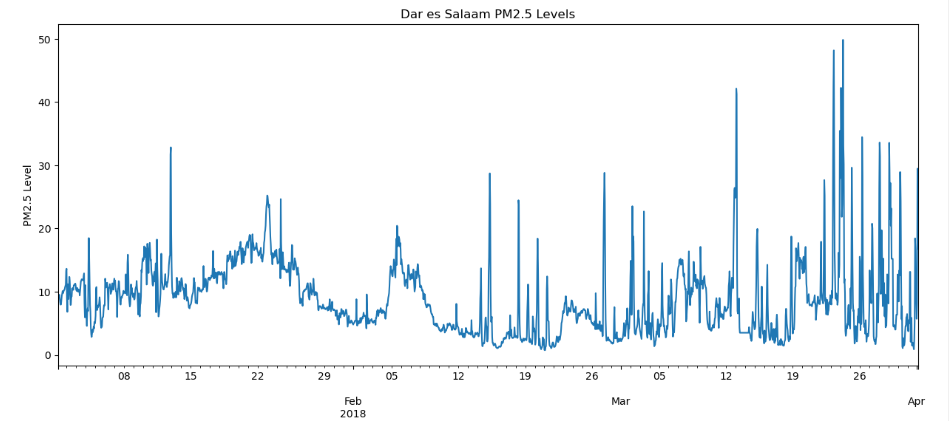

**Task 3.5.6:** Plot the rolling average of the readings in `y`. Use a window size of `168` (the number of hours in a week). Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Dar es Salaam PM2.5 Levels, 7-Day Rolling Average"`.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(title="Dar es Salaam PM2.5 Levels", xlabel="Date", ylabel="PM2.5 Level", ax=ax)  


# Don't delete the code below 👇
plt.savefig("images/3-5-6.png", dpi=150)


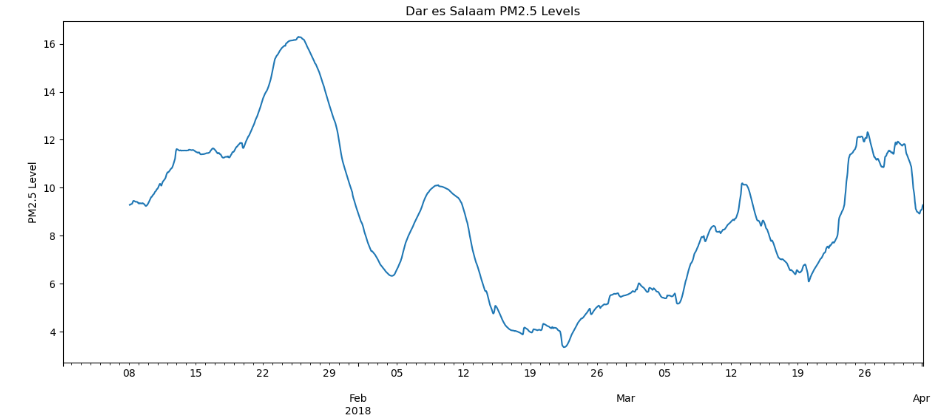

### Rolling Average effect

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample DataFrame with 100 timestamps and random 'P2' values
np.random.seed(42)
timestamps = pd.date_range(start='2022-01-01', periods=100, freq='H')
p2_values = np.random.randint(0, 50, size=100)
df = pd.DataFrame({'timestamp': timestamps, 'P2': p2_values})

# Calculate the rolling mean with a window size of 24 (1 day)
df['rolling_mean_P2'] = df['P2'].rolling(24).mean()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(x='timestamp', y=['P2', 'rolling_mean_P2'], ax=ax, title='P2 and Rolling Mean', ylabel='PM2.5')
plt.legend(['normal','rolling'])
plt.show()


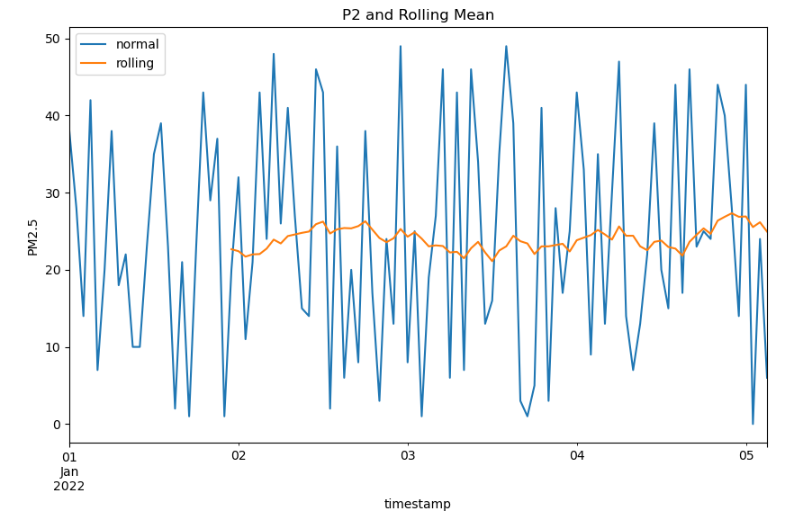

**Task 3.5.7:** Create an ACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam PM2.5 Readings, ACF"`.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.title("Dar es Salaam PM2.5 Readings, ACF")
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
# Don't delete the code below 👇
plt.savefig("images/3-5-7.png", dpi=150)


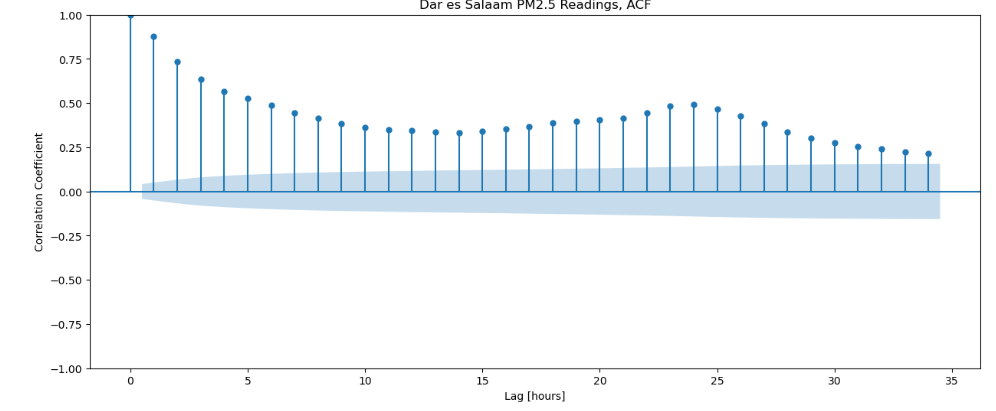

**Task 3.5.8:** Create an PACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam PM2.5 Readings, PACF"`.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.title("Dar es Salaam PM2.5 Readings, PACF")
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
# Don't delete the code below 👇
plt.savefig("images/3-5-8.png", dpi=150)


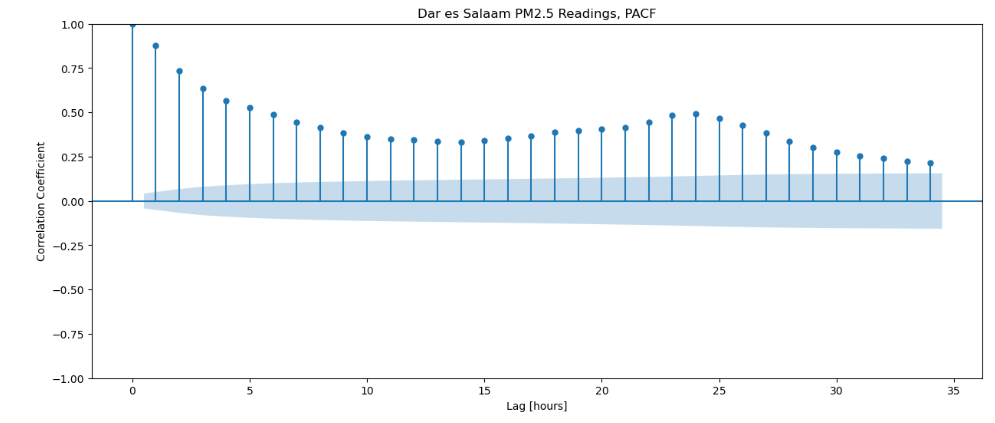

## Split

**Task 3.5.9:** Split `y` into training and test sets. The first 90% of the data should be in your training set. The remaining 10% should be in the test set.

In [ ]:
cutoff_test = int(len(y)*0.9)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(len(y) == y_train.shape[0]+y_test.shape[0])

y_train shape: (1944,)
y_test shape: (216,)
True

# Build Model

In [ ]:
## Baseline

**Task 3.5.10:** Establish the baseline mean absolute error for your model.

In [ ]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

- Mean P2 Reading: 8.57142319061077
- Baseline MAE: 4.053101181299159

## Iterate


Task 3.5.11: You're going to use an AutoReg model to predict PM2.5 readings, but which hyperparameter settings will give you the best performance? Use a for loop to train your AR model on using settings for lags from 1 to 30. Each time you train a new model, calculate its mean absolute error and append the result to the list maes. Then store your results in the Series mae_series.

In [ ]:
# Create range to test different lags
p_params = range(1, 31)

# Create empty list to hold mean absolute error scores
maes = []

# Iterate through all values of p in `p_params`
for p in p_params:
    # Build model
    model = AutoReg(y_train,lags=p).fit()

    # Make predictions on training data, dropping null values caused by lag
    y_pred = model.predict().dropna()

    # Calculate mean absolute error for training data vs predictions
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)

    # Append `mae` to list `maes`
    maes.append(mae)
    

# Put list `maes` into Series with index `p_params`
mae_series = pd.Series(maes, name="mae", index=p_params)

# Inspect head of Series
mae_series.head()

1.    1.059376
2.    1.045182
3.    1.032489
4.    1.032147
5.    1.031022
Name: mae, dtype: float64

**Task 3.5.12:** Look through the results in `mae_series` and determine what value for `p` provides the best performance. Then build and train `best_model` using the best hyperparameter value.

**Note:** Make sure that you build and train your model in one line of code, and that the data type of `best_model` is `statsmodels.tsa.ar_model.AutoRegResultsWrapper`. 

best_p = mae_series.idxmin()
best_model = AutoReg(y_train,lags=best_p).fit()

**Task 3.5.13:** Calculate the training residuals for `best_model` and assign the result to `y_train_resid`. **Note** that your name of your Series should be `"residuals"`.

In [ ]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()


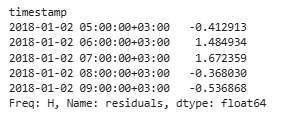

"Best Model, Training Residuals"**Task 3.5.14:** Create a histogram of `y_train_resid`. Be sure to label the x-axis as `"Residuals"` and the y-axis as `"Frequency"`. Use the title `"Best Model, Training Residuals"`.

In [ ]:
# Plot histogram of residuals
y_train_resid.hist()
plt.title("Best Model Training Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
# Don't delete the code below 👇
plt.savefig("images/3-5-14.png", dpi=150)


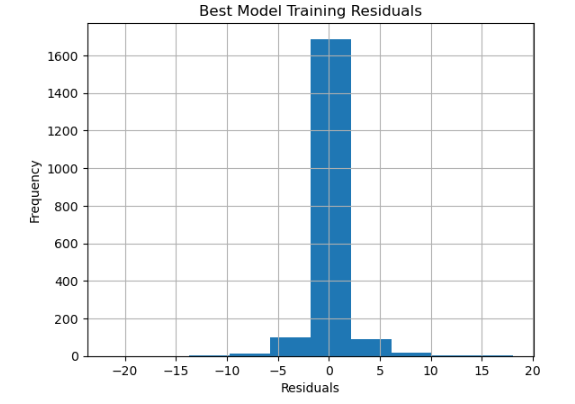

**Task 3.5.15:** Create an ACF plot for `y_train_resid`. Be sure to label the x-axis as `"Lag [hours]"` and y-axis as `"Correlation Coefficient"`. Use the title `"Dar es Salaam, Training Residuals ACF"`.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)
# Don't delete the code below 👇
plt.savefig("images/3-5-15.png", dpi=150)


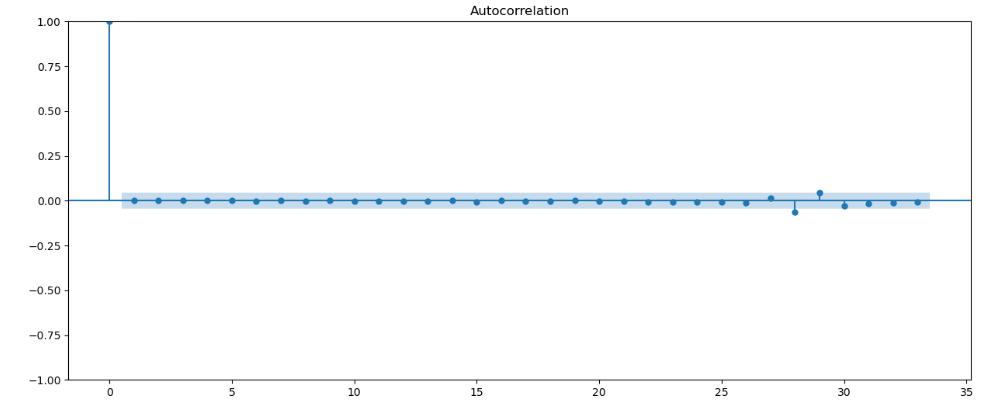

## Evaluate

**Task 3.5.16:** Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. Make sure the name of your Series is `"prediction"` and the name of your Series index is `"timestamp"`.

y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history,lags=best_p).fit()
    new_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(new_pred)
    history = history.append(y_test[new_pred.index])
    
    
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

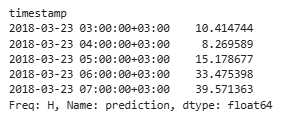

# Communicate Results

**Task 3.5.18:** Put the values for `y_test` and `y_pred_wfv` into the DataFrame `df_pred_test` (don't forget the index). Then plot `df_pred_test` using plotly express. In the legend, your lines should be labeled `"y_test"` and `"y_pred_wfv"`. Be sure to label the x-axis as `"Date"` and the y-axis as `"PM2.5 Level"`. Use the title `"Dar es Salaam, WFV Predictions"`.

In [ ]:
df_pred_test = pd.DataFrame({'y_test':y_test,'y_pred_wfv':y_pred_wfv},index=y_test.index)
fig = px.line(df_pred_test)
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)
# Don't delete the code below 👇
fig.write_image("images/3-5-18.png", scale=1, height=500, width=700)

fig.show()

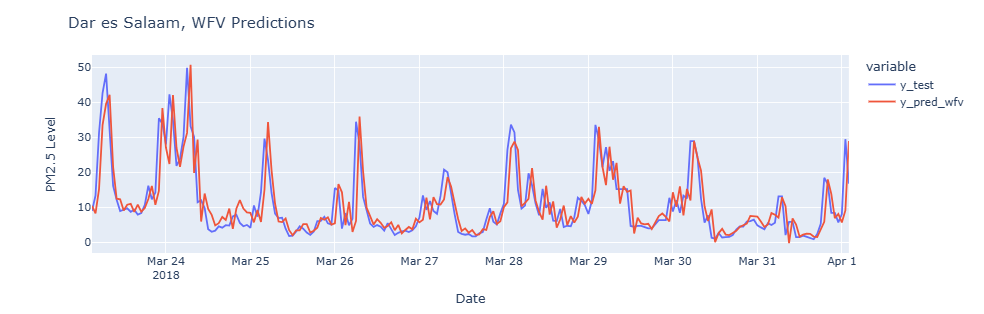